<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import files
import io
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# download from http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv
uploaded = files.upload()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence.csv


In [ ]:


df1 = pd.read_csv(io.StringIO(uploaded['Zip_Zhvi_SingleFamilyResidence.csv'].decode('utf-8')))

# data exploration
print(df1.isna().sum())
print(df1.columns)
df1['RegionName'] = df1['RegionName'].astype(str)
print(df1.dtypes)
#print(df1.describe)
print(df1.head())

In [ ]:
# time series of Hot Springs, Little Rock, Fayetteville, Searcy 
# Present all values from 1997 to present 
# Average at the metro area level

# reshape dataframe on
metro_areas = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

dfAr =  df1[df1['State']=="AR"]
dfAr = dfAr[dfAr['City'].isin(metro_areas)]

# removing 1996 columns
dfAr = dfAr[dfAr.columns.drop(list(dfAr.filter(regex='1996-')))]
dfAr.reset_index(inplace=True)
dfAr = dfAr.drop(columns=['index','RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'CountyName'])

dfAr['Metro'] = dfAr['Metro'].str.replace('Fayetteville-Springdale-Rogers', 'Fayetteville')
dfAr['Metro'] = dfAr['Metro'].str.replace('Little Rock-North Little Rock-Conway', 'Little Rock')
print(dfAr.head())

# aggregating averages across the metros and dates
dfAr_avg = dfAr.groupby('Metro').mean()

# pivoting on dates

# list of date columns
dateCols = list(dfAr_avg.filter(regex='-'))
list(dfAr_avg.index)

In [ ]:
# reshaping dfAr index = columnames, value = dates, column = metro

dfArFinal = pd.melt(dfAr, id_vars=dateCols, value_vars='Metro' )
dfArFinal = dfArFinal.groupby('value').mean()
dfArFinal.reset_index(inplace=True)
dfArFinal.rename(columns={'value':'Metro'}, inplace=True)

dfArFinal = pd.melt(dfArFinal, id_vars='Metro', value_vars=dateCols )
dfArFinal.rename(columns={'value':'Avg', 'variable':'Date'}, inplace=True)
dfArFinal['Date'] = pd.to_datetime(dfArFinal['Date'], infer_datetime_format=True)
dfArFinal.set_index('Date', inplace=True)
print(dfArFinal)


In [6]:
def return_calc(df, metro):
    # takes in df and retro an calculates return
    df1 = df.loc[df['Metro']==metro]
    return round((df1.iloc[-1,1] - df1.iloc[0,1])/df1.iloc[0,1]*100,2)
    

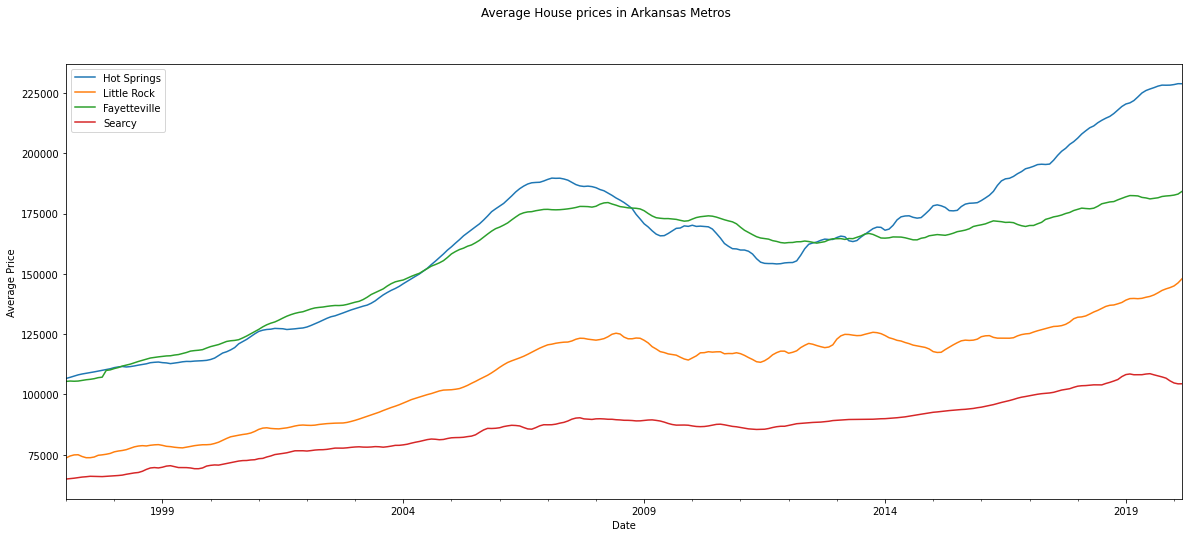

,Metro,Total Return%
0,Fayetteville,114.580000
1,Hot Springs,100.850000
2,Little Rock,74.750000
3,Searcy,60.820000


In [11]:
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Average House prices in Arkansas Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
dfArFinal.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metro_areas)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
summary_table = []
for i in range(len(metro_areas)):
  summary_table.append(return_calc(dfArFinal, metro_areas[i])) 

summary_table=pd.DataFrame(zip(metro_areas,summary_table),columns=["Metro",'Total Return%'])
summary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [18]:
# need to read in data to determine which metros to use 
# pick top 3 by pct change 

incomeGrowth = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/Lab6/main/Incomepermetro.csv",  error_bad_lines=False)
#print(incomeGrowth.dtypes)
incomeGrowth.sort_values('2019 PCt Change Rank', ascending=True, inplace=True)

topFiveIncome = incomeGrowth.nsmallest(5, '2019 PCt Change Rank')
topFiveIncome = topFiveIncome['Metropolitan Statistical Areas2'].str.split(',', expand=True)
topFiveIncome.rename(columns={0:'Metro', 1:'State'}, inplace=True)
topFiveIncome.reset_index(inplace=True)
topFiveIncome.drop(columns='index', inplace=True)
#topFiveIncome = list(topFiveIncome['Metropolitan Statistical Areas2'])
topFiveIncome['Metro'] = topFiveIncome['Metro'].str.replace('Visalia', 'Visalia-Porterville')

print(topFiveIncome)
modelingdf = pd.merge(topFiveIncome, df1, how='inner', on='Metro')
print(modelingdf)
print(modelingdf.columns)
metroList = modelingdf['Metro'].unique()
modelingdateCols = list(modelingdf.filter(regex='-'))

for dates in modelingdateCols:
    colname = str(dates) + 'Rollmean3'
    #print(colname)
    modelingdf[colname]  = modelingdf[dates].rolling( 3,center=True,min_periods=1).mean()
    modelingdf[dates] = modelingdf[colname]
dropCols = list(modelingdf.filter(regex='Rollmean3'))
#drop orignal date columns
modelingdf.drop(columns=dropCols, inplace=True) 

#rename moving average columns

#modelingdf = modelingdf.rename(columns=lambda x: x[:-8] if 'Rollmean3' in x  else x)
print(modelingdf.columns)
print(metroList)

                 Metro State
0            El Centro    CA
1                Chico    CA
2     Hanford-Corcoran    CA
3  Visalia-Porterville    CA
4          Panama City    FL
          Metro State_x  RegionID  ...  2020-01-31 2020-02-29 2020-03-31
0     El Centro      CA     96750  ...    243740.0   245573.0   247389.0
1     El Centro      CA     96740  ...    249671.0   252738.0   255387.0
2     El Centro      CA     96738  ...    240275.0   242748.0   245117.0
3     El Centro      CA     96756  ...    270918.0   273297.0   275827.0
4     El Centro      CA     96775  ...    163163.0   164654.0   166351.0
..          ...     ...       ...  ...         ...        ...        ...
80  Panama City      FL     72021  ...     88657.0    89210.0    89762.0
81  Panama City      FL     72022  ...    168822.0   169796.0   170759.0
82  Panama City      FL     72017  ...    952767.0   950561.0   950677.0
83  Panama City      FL     71999  ...     99937.0   101884.0   103785.0
84  Panama City      FL

                          Metro         Median
Date                                          
1996-01-31     Hanford-Corcoran   95645.000000
1996-01-31          Panama City   97946.000000
1996-01-31  Visalia-Porterville   84261.000000
1996-02-29            El Centro   43697.000000
1996-02-29     Hanford-Corcoran   95496.000000
...                         ...            ...
2020-03-31                Chico  249438.333333
2020-03-31            El Centro  223782.333333
2020-03-31     Hanford-Corcoran  178574.000000
2020-03-31          Panama City  225755.833333
2020-03-31  Visalia-Porterville  212304.000000

[1442 rows x 2 columns]


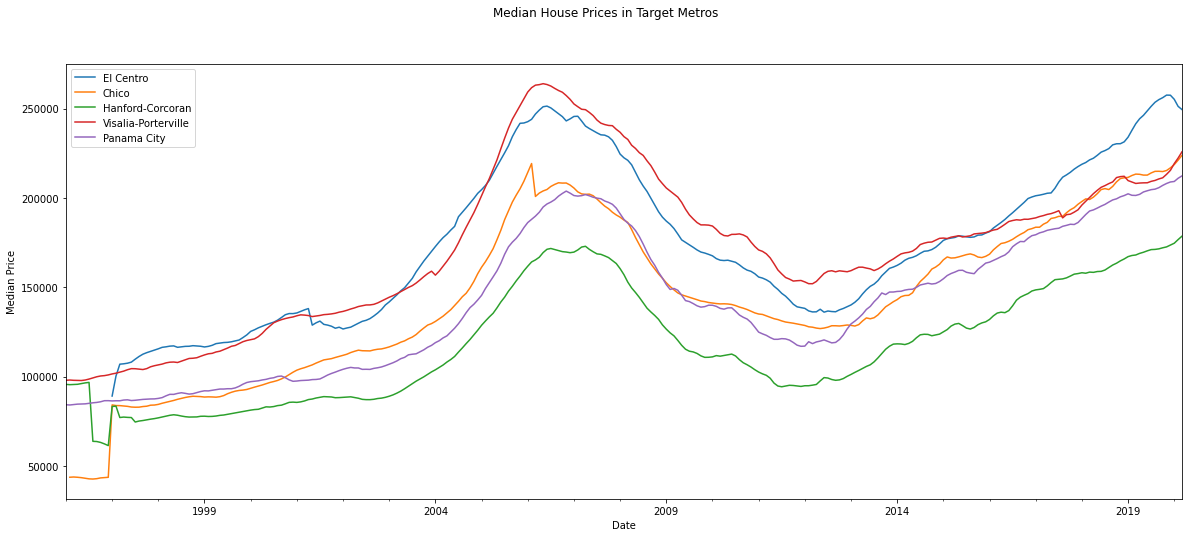

,Metro,Total Return%
0,El Centro,412.120000
1,Chico,179.870000
2,Visalia-Porterville,151.960000
3,Panama City,130.490000
4,Hanford-Corcoran,86.710000


In [19]:
# transforming modeldf so time series analysis for the plots
# reshaping dfAr index = columnames, value = dates, column = metro

modelingdfplot = pd.melt(modelingdf, id_vars=modelingdateCols, value_vars='Metro' )
modelingdfplot = modelingdfplot.groupby('value').median()
modelingdfplot.reset_index(inplace=True)
modelingdfplot.rename(columns={'value':'Metro'}, inplace=True)

modelingdfplot = pd.melt(modelingdfplot, id_vars='Metro', value_vars=modelingdateCols )
modelingdfplot.rename(columns={'value':'Median', 'variable':'Date'}, inplace=True)

modelingdfplot['Date'] = pd.to_datetime(modelingdfplot['Date'], infer_datetime_format=True)
modelingdfplot.set_index('Date', inplace=True)
modelingdfplot.dropna(inplace=True)
print(modelingdfplot)
# time series plots of Avg price over time

fig, ax = plt.subplots()
fig.suptitle('Median House Prices in Target Metros')
fig.set_figheight(8)
fig.set_figwidth(20)

# Additional customizations
ax.set_xlabel('Date')
ax.set_ylabel('Median Price')
modelingdfplot.groupby('Metro').plot( ax=ax, label='Metro')
plt.legend(metroList)
#dfArFinal.plot(ax=ax,label=dfArFinal['Metro'])
plt.show()

# return summary
returnSummary_table = []
for i in range(len(metroList)):
  returnSummary_table.append(return_calc(modelingdfplot, metroList[i])) 

returnSummary_table=pd.DataFrame(zip(metroList,returnSummary_table),columns=["Metro",'Total Return%'])
returnSummary_table.sort_values('Total Return%', ascending=False, ignore_index=True).style


In [20]:
# melting the full dataframe to create forecast of median house price per zip code from 2018 (1997-2017) as training set

#print(*df1.columns, sep = "\n")
# region name == zipcode
print(modelingdf.head())
# dropping columns 
modelingdf = modelingdf[modelingdf.columns.drop(list(modelingdf.filter(regex='1996-')))]
modelingdf.reset_index(inplace=True)
modelingdf = modelingdf.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'City', 'CountyName'])

mainDateCols = list(modelingdf.filter(regex='-'))
modelingdf = pd.melt(modelingdf, id_vars=mainDateCols, value_vars='RegionName', value_name='ZipCode' )
modelingdf = modelingdf.groupby('ZipCode').median()

modelingdf.reset_index(inplace=True)
modelingdf = pd.melt(modelingdf, id_vars='ZipCode', value_vars=mainDateCols , var_name='Date', value_name='Median_Home_Value')
modelingdf = pd.pivot_table(data=modelingdf,
    index='Date',
    columns='ZipCode',
   values = 'Median_Home_Value'
    ).reset_index()
modelingdf['Date'] = pd.to_datetime(modelingdf['Date'], infer_datetime_format=True)
modelingdf.set_index('Date', inplace=True)
modelingdf.head()



       Metro State_x  RegionID  ...     2020-01-31     2020-02-29     2020-03-31
0  El Centro      CA     96750  ...  246705.500000  249155.500000  251388.000000
1  El Centro      CA     96740  ...  244562.000000  247019.666667  249297.666667
2  El Centro      CA     96738  ...  253621.333333  256261.000000  258777.000000
3  El Centro      CA     96756  ...  224785.333333  226899.666667  229098.333333
4  El Centro      CA     96775  ...  218637.333333  221112.000000  223782.333333

[5 rows x 301 columns]


ZipCode,32401,32404,32405,32407,32408,32409,32413,32438,32444,32449,32456,32461,32465,32466,92227,92231,92233,92243,92249,92250,92251,92273,92274,92275,92281,93201,93202,93204,93207,93212,93218,93219,93221,93223,93227,93230,93235,93239,93244,93245,...,93265,93266,93267,93270,93271,93272,93274,93277,93282,93286,93291,93292,93603,93615,93618,93647,93666,93670,95914,95916,95917,95925,95926,95928,95930,95938,95941,95942,95948,95954,95958,95965,95966,95968,95969,95972,95973,95974,95978,96092
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-31,97302.666667,109493.5,116339.000000,101502.666667,104656.666667,98294.000000,93840.000000,440163.0,94767.333333,NaN,89653.0,259952.0,87743.0,259952.0,89608.333333,84172.333333,107017.0,81882.5,100316.0,81432.333333,76477.000000,NaN,78098.000000,124706.0,NaN,NaN,83264.0,72060.5,64423.0,60857.0,64423.0,91155.666667,89062.000000,78211.000000,43375.0,104700.0,66185.666667,97871.0,64423.0,82778.500000,...,88347.000000,83264.0,90627.666667,72897.5,72111.333333,47984.666667,91122.5,106236.000000,88135.0,86397.333333,116693.000000,111012.333333,NaN,81855.5,100654.333333,88381.666667,NaN,NaN,NaN,89127.0,89127.0,NaN,129005.5,129005.500000,NaN,83875.000000,NaN,NaN,90245.500000,82660.666667,104700.0,82053.500000,67491.000000,89127.000000,NaN,NaN,133305.000000,NaN,NaN,NaN
1997-02-28,97734.000000,110118.5,116924.333333,101922.000000,105134.000000,98336.666667,94185.000000,443694.0,95163.666667,NaN,89373.5,261880.5,87561.5,261880.5,89096.333333,83803.000000,107536.0,81614.5,100254.5,81486.333333,76342.333333,NaN,77940.000000,124142.0,NaN,NaN,83489.0,72017.5,65116.0,82706.5,65116.0,91015.333333,89218.666667,78146.333333,43128.0,104572.0,66146.000000,97981.0,65116.0,89896.666667,...,88152.333333,83489.0,90395.333333,72660.5,72008.666667,48095.333333,91205.0,106270.666667,88603.0,86488.666667,116735.333333,111084.666667,NaN,81591.0,100728.333333,88498.333333,NaN,NaN,NaN,96376.0,72833.0,NaN,128788.0,134262.333333,NaN,111110.666667,NaN,56411.000000,109144.000000,83277.666667,104277.0,79934.333333,95805.666667,72833.000000,124445.0,NaN,117685.666667,NaN,NaN,NaN
1997-03-31,98305.666667,110651.5,117521.333333,102512.333333,105510.666667,98547.333333,94585.666667,447911.0,95496.666667,NaN,89410.5,263736.0,87027.5,263736.0,89006.000000,83772.666667,107626.0,81551.0,100359.5,81493.666667,76457.000000,NaN,78082.666667,123929.0,NaN,NaN,69708.5,71718.0,64889.0,82385.5,64889.0,90724.333333,89093.666667,78140.000000,43266.0,104164.0,66049.333333,77119.5,64889.0,89564.000000,...,87855.333333,69708.5,89811.000000,72199.0,71822.000000,48247.000000,91081.5,106011.333333,89216.0,86481.666667,116496.000000,110898.333333,NaN,81252.0,100593.666667,88427.666667,NaN,NaN,112482.0,97505.5,73931.5,NaN,128794.5,134147.000000,NaN,112001.333333,121443.0,94128.333333,110009.666667,84329.333333,103921.0,80797.333333,96216.666667,83794.666667,125156.5,NaN,117869.000000,NaN,NaN,NaN
1997-04-30,98663.666667,111246.5,117797.000000,103069.333333,105904.666667,99039.333333,94810.333333,454506.0,95846.000000,NaN,89932.5,266868.5,86961.0,266868.5,88586.666667,83560.666667,107919.0,81244.0,100658.0,81756.333333,76644.666667,NaN,78379.000000,123366.0,NaN,NaN,69251.5,71096.5,64403.0,82223.0,64403.0,90228.000000,89222.333333,78534.333333,43325.0,103713.0,66163.666667,77364.0,64403.0,89230.333333,...,87491.666667,69251.5,89148.000000,72268.5,71717.666667,48596.000000,91250.5,106092.000000,90029.0,86891.000000,116707.000000,111126.333333,NaN,80916.5,100756.000000,88759.666667,NaN,NaN,112569.0,98881.5,75377.0,NaN,128721.5,134176.333333,NaN,112848.333333,120748.0,94533.333333,111096.666667,85928.000000,103245.0,81788.333333,96745.000000,85048.000000,125566.5,NaN,118052.000000,NaN,NaN,NaN
1997-05-31,99309.333333,112387.5,118323.333333,103869.333333,106816.000000,99741.666667,95330.666667,457713.0,96632.666667,NaN,90711.5,268480.0,87236.5,268480.0,88285.000000,83361.666667,108257.0,80848.0,101301.5,82223.000000,7688

In [175]:
def Arima_modeling(df, columnName):
  # Arima Model testing and fitting for Zip Code List
  subsetdf = df[[columnName]]
  # subsetting from 1997-2017
  traindf =subsetdf.loc['1997-01-31':'2017-12-31']
  testdf = subsetdf.loc['2018-01-31':]


  # create a differenced series
  traindf['firstDiff'] = traindf[columnName].diff(periods=1)
  traindf['log'] = np.log(traindf[columnName])

  # adf test
  traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
  result1 = adfuller(traindf['firstDiff'])
  result2 = adfuller(traindf['log'])
  

  if result1[1] < 0.05:
    #first diff model
    
    print('First difference')
    print('ADF Statistic: %f' % result1[0])
    print('p-value: %f' % result1[1])    
    traindf['firstDiff'].plot()
    plt.show()
    parameters = []
    for pindex in range(3):
        for qindex in range(3):
          p = pindex + 1 
          q = qindex + 1
          try:
            Model1 = ARIMA(traindf[columnName], order = (p,1,q)).fit()
          except ValueError:
            pass
          #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)
          # need a dictionary to save this p,q, aic
          param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
          parameters.append(param)
    # finding best parameters
    modelparams = pd.DataFrame(parameters)
    bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
    # fitting best model
    Fitted_model = ARIMA(traindf[columnName],
                         order = (int(bestparams.iloc[0]['AR'])
                         ,1
                         ,int(bestparams.iloc[0]['MA']))).fit()

    # returning model and test df
    return Fitted_model, testdf

  elif result2[1] < 0.05:
    # log model
    print('Log')
    print('ADF Statistic: %f' % result2[0])
    print('p-value: %f' % result2[1])
    traindf['log'].plot()
    plt.show()
    parameters = []
    for pindex in range(3):
        for qindex in range(3):
          p = pindex + 1 
          q = qindex + 1
          try:
            Model1 = ARIMA(traindf['log'], order = (p,1,q)).fit()
          except ValueError:
            pass  
          # need a dictionary to save this p,q, aic
          #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)
          param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
          parameters.append(param)

    # finding best parameters
    modelparams = pd.DataFrame(parameters)
    bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
    # fitting best model
    Fitted_model = ARIMA(traindf['log'],
                         order = (int(bestparams.iloc[0]['AR'])
                         ,1
                         ,int(bestparams.iloc[0]['MA']))).fit()
  # doing log calculation on test df
    testdf['log']  = np.log(testdf[columnName])
    traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
    testdf[columnName] = testdf['log']
    return Fitted_model, testdf

  else:
    return print('Series is not stable!')


  

In [186]:
def Arima_forecast(model, testdf, zipcode):
  # forecasting
  predictions = list()

  # walk-forward validation
  predictions = model.forecast(steps=len(testdf))[0]
  predictionsdf = pd.DataFrame({'Date':testdf.index,'Predictions': predictions })
  predictionsdf.set_index('Date', inplace=True)

  # evaluate forecasts
  rmse = sqrt(mean_squared_error(testdf[zipcode], predictions))
  
  #returnval = round((predictionsdf.iloc[-1,0] - predictionsdf.iloc[0,0])/predictionsdf.iloc[0,0]*100,2)
  #print('Test RMSE: %.3f' % rmse)

  returnval = round((predictionsdf.iloc[-1,0] - predictionsdf.iloc[0,0])/predictionsdf.iloc[0,0]*100,2)

    # plot forecasts against actual outcomes
  plt.title('Forecast for '+ zipcode)
  plt.plot(testdf[zipcode])
  plt.plot(predictionsdf, color='red')
  plt.show()
  return rmse, returnval


In [ ]:
forecastedReturns = pd.DataFrame(columns=['ZipCode','RSME', 'Return'])
# model testing/fitting and return forecast
for zipcode in list(modelingdf.columns):
  if zipcode == '32461' or zipcode == '93258' or zipcode == '93603' or zipcode =='95925':
    pass
  else:
    print("-------------------------------------------------------------")

    try:
    
      print('Zipcode: '+ zipcode)
      try:
        model, testdf = Arima_modeling(modelingdf, zipcode)
        print(model.summary())
        #model verification and forecast
        rsme, returnval = Arima_forecast(model, testdf, zipcode)
        print("RSME: "+ str(rsme))
        print("Projected Return: " + str(returnval) + '%')
        # adding Selection criteria values to final analysis dataframe
        forecastedReturns = forecastedReturns.append({'ZipCode': zipcode,
                                                      'RSME':rsme,
                                                      'Return': returnval},
                                                      ignore_index=True) 
      except TypeError:
        print('TypeError')

    except ValueError:
      print('Zipcode: '+ zipcode)
      print('Series is not stable!')


   ZipCode          RSME  Return
23   95978  11290.561534   12.33
10   93201   1472.784217   11.78
18   95930   4379.383267   11.06
14   93256   5489.691479   11.01
20   95969  20156.513482   10.18
16   95914   9003.789965   10.06
-------------------------------------------------------------
Zipcode: 93201
First difference
ADF Statistic: -5.677121
p-value: 0.000001


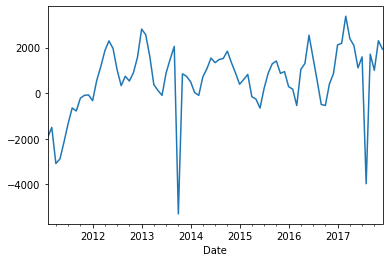

                             ARIMA Model Results                              
Dep. Variable:                D.93201   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -703.624
Method:                       css-mle   S.D. of innovations           1287.283
Date:                Sun, 22 Aug 2021   AIC                           1415.248
Time:                        18:07:43   BIC                           1424.875
Sample:                    03-31-2011   HQIC                          1419.113
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           606.5463    300.463      2.019      0.047      17.649    1195.444
ar.L1.D.93201     0.6614      0.172      3.855      0.000       0.325       0.998
ma.L1.D.93201    -0.2725      0.203     

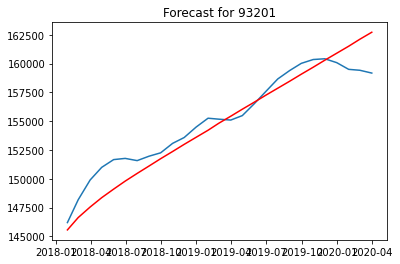

RSME: 1472.7842172167743
Projected Return: 11.78%
-------------------------------------------------------------
Zipcode: 93256
First difference
ADF Statistic: -3.223460
p-value: 0.018666


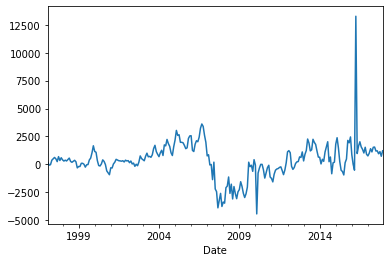

                             ARIMA Model Results                              
Dep. Variable:                D.93256   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2113.319
Method:                       css-mle   S.D. of innovations           1132.862
Date:                Sun, 22 Aug 2021   AIC                           4234.638
Time:                        18:07:47   BIC                           4248.724
Sample:                    03-31-1997   HQIC                          4240.308
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           403.9800    445.814      0.906      0.366    -469.799    1277.759
ar.L1.D.93256     0.9418      0.026     36.034      0.000       0.891       0.993
ma.L1.D.93256    -0.6176      0.064     

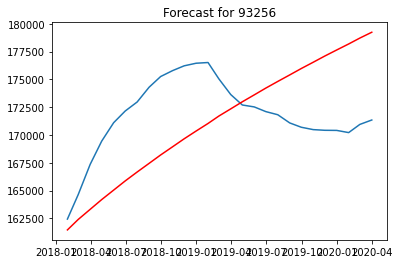

RSME: 5489.691478568591
Projected Return: 11.01%
-------------------------------------------------------------
Zipcode: 95914
First difference
ADF Statistic: -3.640605
p-value: 0.005031


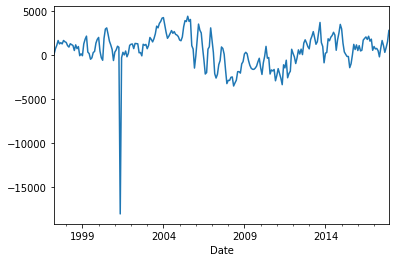

                             ARIMA Model Results                              
Dep. Variable:                D.95914   No. Observations:                  248
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2181.530
Method:                       css-mle   S.D. of innovations           1597.527
Date:                Sun, 22 Aug 2021   AIC                           4373.061
Time:                        18:07:50   BIC                           4390.628
Sample:                    05-31-1997   HQIC                          4380.133
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           621.7439    521.452      1.192      0.234    -400.283    1643.771
ar.L1.D.95914     1.2424      0.101     12.254      0.000       1.044       1.441
ar.L2.D.95914    -0.2771      0.087     

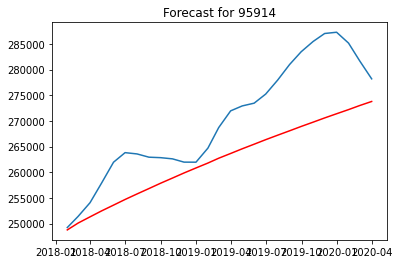

RSME: 9003.789965302769
Projected Return: 10.06%
-------------------------------------------------------------
Zipcode: 95930
First difference
ADF Statistic: -5.486410
p-value: 0.000002


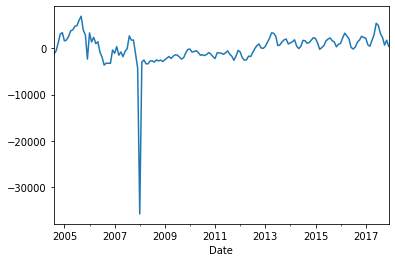

                             ARIMA Model Results                              
Dep. Variable:                D.95930   No. Observations:                  160
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1513.706
Method:                       css-mle   S.D. of innovations           3103.277
Date:                Sun, 22 Aug 2021   AIC                           3037.411
Time:                        18:07:56   BIC                           3052.787
Sample:                    09-30-2004   HQIC                          3043.655
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           324.6793   1000.254      0.325      0.746   -1635.782    2285.140
ar.L1.D.95930     1.1530      0.123      9.354      0.000       0.911       1.395
ar.L2.D.95930    -0.1919      0.101     

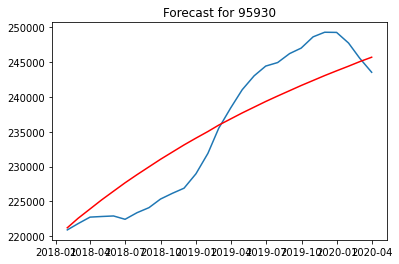

RSME: 4379.383266771111
Projected Return: 11.06%
-------------------------------------------------------------
Zipcode: 95969
First difference
ADF Statistic: -3.251370
p-value: 0.017197


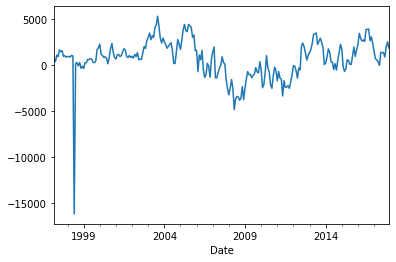

                             ARIMA Model Results                              
Dep. Variable:                D.95969   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2170.991
Method:                       css-mle   S.D. of innovations           1477.510
Date:                Sun, 22 Aug 2021   AIC                           4349.982
Time:                        18:08:00   BIC                           4364.052
Sample:                    04-30-1997   HQIC                          4355.645
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           737.5702    549.990      1.341      0.181    -340.390    1815.530
ar.L1.D.95969     0.9269      0.031     30.233      0.000       0.867       0.987
ma.L1.D.95969    -0.5519      0.073     

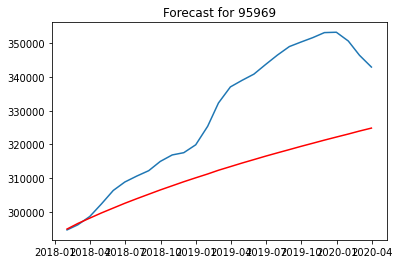

RSME: 20156.513482446986
Projected Return: 10.18%
-------------------------------------------------------------
Zipcode: 95978
First difference
ADF Statistic: -3.779377
p-value: 0.003126


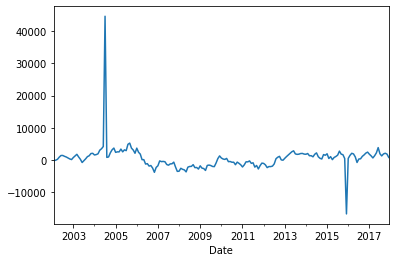

                             ARIMA Model Results                              
Dep. Variable:                D.95978   No. Observations:                  190
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1826.200
Method:                       css-mle   S.D. of innovations           3610.844
Date:                Sun, 22 Aug 2021   AIC                           3660.401
Time:                        18:08:05   BIC                           3673.389
Sample:                    03-31-2002   HQIC                          3665.662
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           587.2673    793.967      0.740      0.460    -968.880    2143.414
ar.L1.D.95978     0.9356      0.041     22.675      0.000       0.855       1.016
ma.L1.D.95978    -0.7948      0.070    -

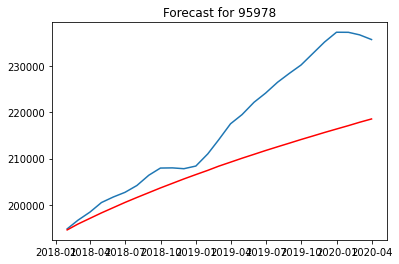

RSME: 11290.561533977905
Projected Return: 12.33%


In [199]:
#final Zip Code list and model reports
finalZipCodeList = forecastedReturns[forecastedReturns['Return'] > 10.00]
print(finalZipCodeList.sort_values(by='Return', ascending=False))

for zipcode in list(finalZipCodeList['ZipCode'].unique()):

  print("-------------------------------------------------------------")

  try:
    
    print('Zipcode: '+ zipcode)
    try:
      model, testdf = Arima_modeling(modelingdf, zipcode)
      print(model.summary())
      #model verification and forecast
      rsme, returnval = Arima_forecast(model, testdf, zipcode)
      print("RSME: "+ str(rsme))
      print("Projected Return: " + str(returnval) + '%')
        # adding Selection criteria values to final analysis dataframe

    except TypeError:
      print('TypeError')

  except ValueError:
    print('Zipcode: '+ zipcode)
    print('Series is not stable!')


